### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_valid'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

plot_gene = 'CTNNB1'
metric = 'aupr'
nz_cutoff = 5.0

output_plots = True
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
# TODO: only load for relevant gene
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df = nz_coefs_df[nz_coefs_df.gene == plot_gene].copy()
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,PRDM1,PRAD,0.005,42,0,5133
1,PRDM1,PRAD,0.005,42,1,5160
2,PRDM1,PRAD,0.005,42,2,5783
3,PRDM1,PRAD,0.005,42,3,6330
4,PRDM1,PRAD,0.01,42,0,2925


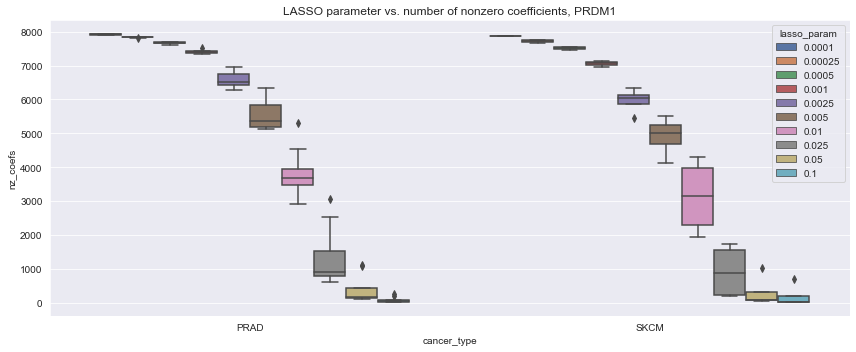

In [4]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)
plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset,
                                                 gene=plot_gene)
perf_df = perf_df[perf_df.gene == plot_gene].copy()
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.000000,PRDM1,PRAD,signal,1,train,0,all_other_cancers,0.001
1,0.45687,0.115690,PRDM1,PRAD,signal,1,test,0,all_other_cancers,0.001
2,0.25581,0.015385,PRDM1,PRAD,signal,1,cv,0,all_other_cancers,0.001
3,1.00000,1.000000,PRDM1,PRAD,signal,1,train,1,all_other_cancers,0.001
4,0.45204,0.096150,PRDM1,PRAD,signal,1,test,1,all_other_cancers,0.001


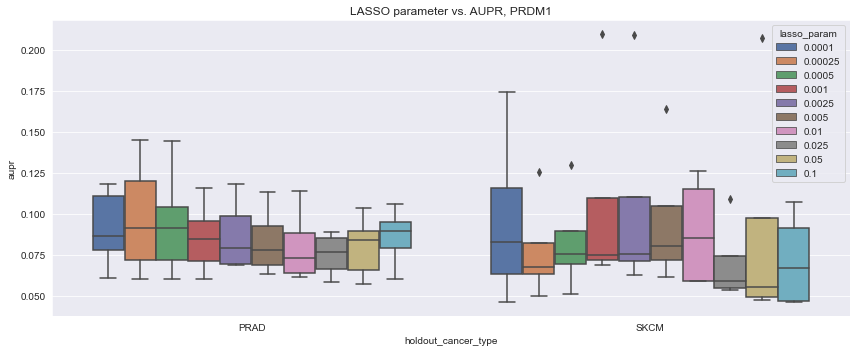

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='holdout_cancer_type', y=metric, hue='lasso_param'
)
plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}')
plt.tight_layout()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_boxes.png',
                dpi=200, bbox_inches='tight')

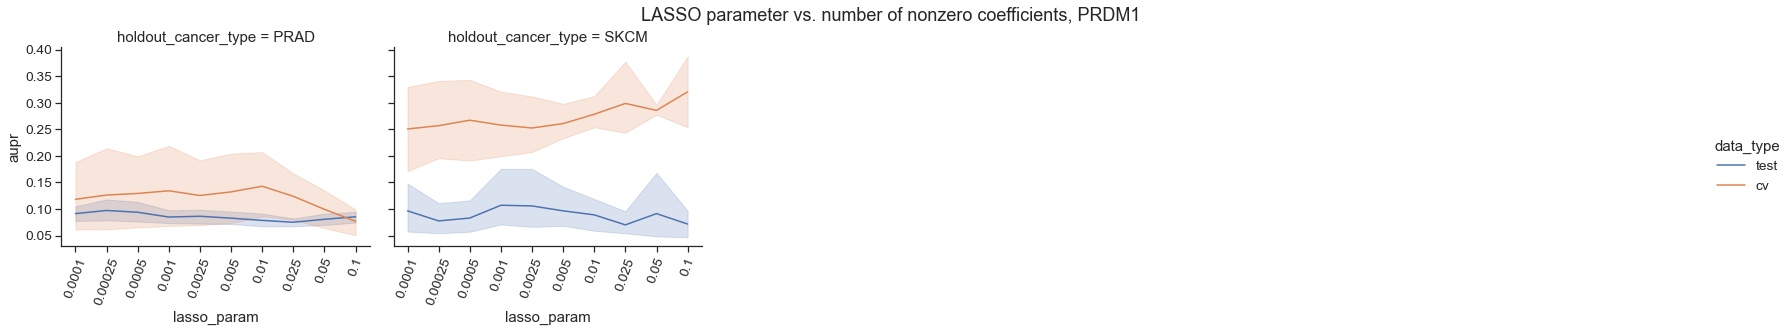

In [7]:
sns.set({'figure.figsize': (12, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal') &
            (perf_df.data_type.isin(['cv', 'test']))]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)

with sns.plotting_context('notebook', font_scale=1.25):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        kind='line', col='holdout_cancer_type',
        col_wrap=5, height=4, aspect=1.2
    )
    g.set_xticklabels(rotation=70)
    plt.suptitle(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}', y=1.025)

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_facets.png',
                dpi=200, bbox_inches='tight')

### Compare feature selection with performance

In [8]:
coefs_perf_df = (nz_coefs_df
    .rename(columns={'cancer_type': 'holdout_cancer_type'})
    .merge(perf_df[perf_df.signal == 'signal'],
           on=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param'])
    .drop(columns=['signal'])
)

coefs_perf_df.head()

,gene,holdout_cancer_type,lasso_param,seed,fold,nz_coefs,auroc,aupr,data_type,experiment
0,PRDM1,PRAD,0.005,42,0,5133,1.00000,1.000000,train,all_other_cancers
1,PRDM1,PRAD,0.005,42,0,5133,0.37838,0.063233,test,all_other_cancers
2,PRDM1,PRAD,0.005,42,0,5133,0.51707,0.102700,cv,all_other_cancers
3,PRDM1,PRAD,0.005,42,1,5160,0.99857,0.982180,train,all_other_cancers
4,PRDM1,PRAD,0.005,42,1,5160,0.29274,0.067594,test,all_other_cancers


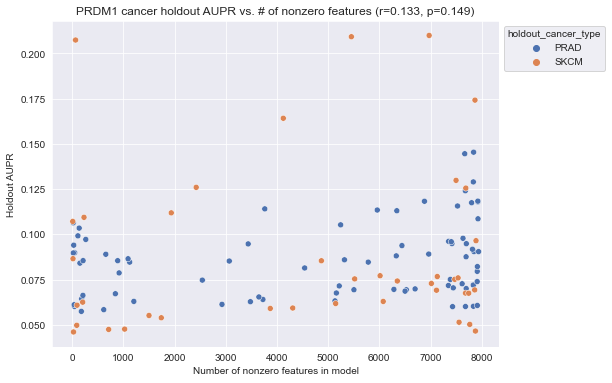

In [9]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

plot_df = (
    coefs_perf_df[coefs_perf_df.data_type == 'test']
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_holdout_perf.png',
                dpi=200, bbox_inches='tight')

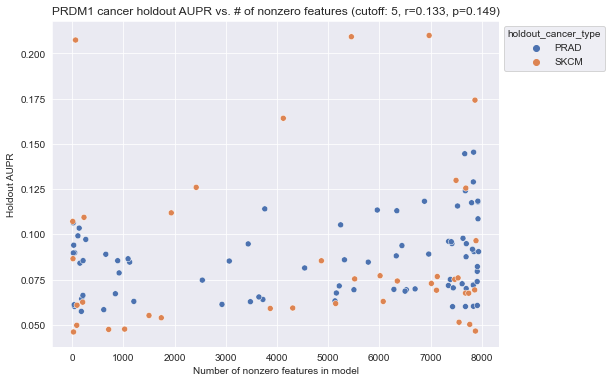

In [10]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

plot_df = (
    coefs_perf_df[(coefs_perf_df.data_type == 'test') &
                  (coefs_perf_df.nz_coefs > nz_cutoff)]
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (cutoff: {nz_cutoff:.0f}, r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_holdout_perf.png',
                dpi=200, bbox_inches='tight')

In [11]:
# look at correlation for each cancer type individually
# positive correlation => more features, better performance
corr_cancer_type_df = []

for cancer_type in coefs_perf_df.holdout_cancer_type.unique():
    corr_df = coefs_perf_df[
        (coefs_perf_df.holdout_cancer_type == cancer_type) &
        (coefs_perf_df.data_type == 'test')
    ]
    r, p = pearsonr(corr_df.nz_coefs.values, corr_df.aupr.values)
    corr_cancer_type_df.append(
        [plot_gene, cancer_type, r, p]
    )
    
corr_cancer_type_df = pd.DataFrame(
    corr_cancer_type_df,
    columns=['gene', 'cancer_type', 'pearson_r', 'pearson_pval']
).sort_values(by='pearson_r', ascending=False)

corr_cancer_type_df

,gene,cancer_type,pearson_r,pearson_pval
0,PRDM1,PRAD,0.241839,0.030678
1,PRDM1,SKCM,0.059715,0.714348


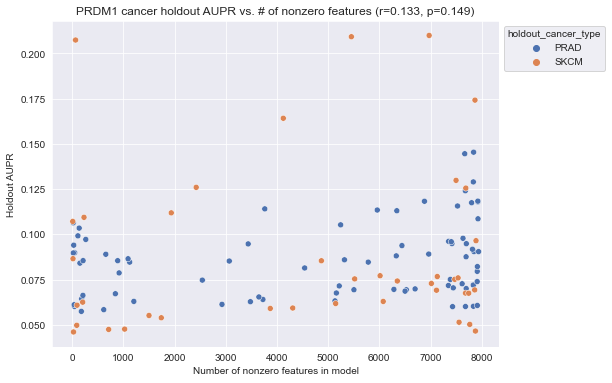

In [12]:
# plot test performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

top_cancers = corr_cancer_type_df.cancer_type.values[:5]
    
plot_df = (
    coefs_perf_df[(coefs_perf_df.holdout_cancer_type.isin(top_cancers)) &
                  (coefs_perf_df.data_type == 'test')]
      .sort_values(by='holdout_cancer_type')
)
r, p = pearsonr(plot_df.nz_coefs.values, plot_df.aupr.values)

ax = sns.scatterplot(data=plot_df, x='nz_coefs', y='aupr', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} cancer holdout AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Holdout AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_holdout_perf_top_cancers.png',
                dpi=200, bbox_inches='tight')

In [13]:
coefs_perf_pivot_df = coefs_perf_df.pivot(
    index=['gene', 'holdout_cancer_type', 'seed', 'fold', 'lasso_param', 'nz_coefs'],
    columns='data_type',
    values=['auroc', 'aupr']
)
coefs_perf_pivot_df.columns = ['_'.join(col).strip() for col in coefs_perf_pivot_df.columns.values]
coefs_perf_pivot_df.reset_index(inplace=True)

coefs_perf_pivot_df

,gene,holdout_cancer_type,seed,fold,lasso_param,nz_coefs,auroc_cv,auroc_test,auroc_train,aupr_cv,aupr_test,aupr_train
0,PRDM1,PRAD,1,0,0.0001,7924,0.38372,0.45687,1.00000,0.018519,0.118380,1.00000
1,PRDM1,PRAD,1,0,0.00025,7802,0.27907,0.45755,1.00000,0.015873,0.117490,1.00000
2,PRDM1,PRAD,1,0,0.0005,7680,0.22093,0.47102,1.00000,0.014706,0.124110,1.00000
3,PRDM1,PRAD,1,0,0.001,7527,0.25581,0.45687,1.00000,0.015385,0.115690,1.00000
4,PRDM1,PRAD,1,0,0.0025,6881,0.33721,0.45620,1.00000,0.017241,0.118310,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
115,PRDM1,SKCM,42,3,0.005,5517,0.68778,0.61828,0.99618,0.234110,0.075387,0.96449
116,PRDM1,SKCM,42,3,0.01,4307,0.73468,0.50000,0.98253,0.321720,0.059290,0.83611
117,PRDM1,SKCM,42,3,0.025,1499,0.70712,0.47312,0.94212,0.286450,0.055163,0.54615
118,PRDM1,SKCM,42,3,0.05,1023,0.69971,0.38172,0.88560,0.283980,0.047639,0.34374


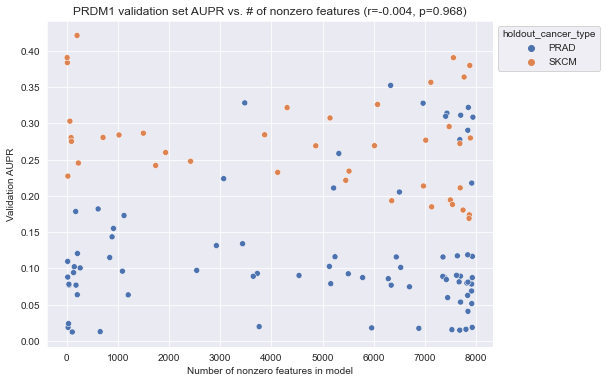

In [14]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.aupr_cv.values)

ax = sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='aupr_cv', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} validation set AUPR vs. # of nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('Validation AUPR')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_validation_perf.png',
                dpi=200, bbox_inches='tight')

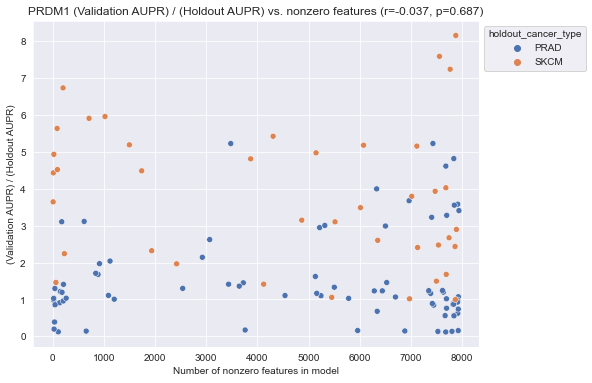

In [15]:
# plot validation performance vs. number of nonzero features
sns.set({'figure.figsize': (8, 6)})

coefs_perf_pivot_df['cv_test_aupr_ratio'] = (
    coefs_perf_pivot_df['aupr_cv']/ coefs_perf_pivot_df['aupr_test']
)
r, p = pearsonr(coefs_perf_pivot_df.nz_coefs.values, coefs_perf_pivot_df.cv_test_aupr_ratio.values)

ax = sns.scatterplot(data=coefs_perf_pivot_df, x='nz_coefs', y='cv_test_aupr_ratio', hue='holdout_cancer_type')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title(f'{plot_gene} (Validation AUPR) / (Holdout AUPR) vs. nonzero features (r={r:.3f}, p={p:.3f})')
plt.xlabel('Number of nonzero features in model')
plt.ylabel('(Validation AUPR) / (Holdout AUPR)')

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_features_vs_perf_ratio.png',
                dpi=200, bbox_inches='tight')

For this limited set of genes/cancer types, there doesn't seem to be much of a relationship between model size and "performance", for any of these three ways of defining performance.

A better way to explore correlation between model size and performance might be to look at the partial correlation while controlling for cancer type - we'll explore this in the future.